In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import pandas as pd

In [2]:
df = pd.read_csv('data.csv')
# df1 = df[df["Personal Loan"]==1]
# df0 = df[df["Personal Loan"]==0][:480]
# df = pd.concat((df0,df1))
# df = df.sample(frac=1)
df.drop("ID",axis=1,inplace=True)

features = df.drop("Personal Loan",axis=1).columns
target = "Personal Loan"

from sklearn.model_selection import train_test_split

trainx,testx,trainy,testy = train_test_split(df[features],df[target],test_size=0.2)

traindb = pd.concat((trainx,trainy),axis=1)
testdb = pd.concat((testx,testy),axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class db(Dataset):
    def __init__(self,target,features,df) -> None:
        self.y  = torch.tensor(df[target].values)
        self.x = torch.tensor(df[features].values)
        self.x = scaler.fit_transform(self.x)

    def __len__(self) -> int:
        return len(self.y)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

traindbt = db(target,features,traindb)
testdbt = db(target,features,testdb)

train_loader = DataLoader(traindbt,batch_size=len(traindb),shuffle=True)
test_loader = DataLoader(testdbt,batch_size=len(testdb),shuffle=False)

In [3]:
class net(nn.Module):
    def __init__(self) -> None:
        super(net,self).__init__()

        self.l1 = nn.Linear(12,16)
        self.l2 = nn.ReLU()
        self.l3 = nn.Linear(16,1)
        self.l4 = nn.Sigmoid()
        # self.l5 = nn.Linear(20,1)
        # self.l6 = nn.Sigmoid()
    
    def forward(self,X):
        
        x = X

        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        # x = self.l5(x)
        # x = self.l6(x)

        return x
    
    def flattened_weights(self):
        p = []
        params = list(self.parameters()).copy()
        for i in range(len(params)):
            p += params[i].flatten().detach().tolist()
        p = np.array(p)

        return p

In [4]:
model = net()
model = model.to(torch.float32)
loss = nn.BCELoss()
epochs = 1000

n = model.flattened_weights().shape[0] # Problem Space Dimension
k = 100 # No. of solutions i.e no. of ants
m = 50 # No. of new solutions generated
q = 0.6 # Determines the quality of the solutions chosen
e = 0.4 # Inversely influences convergence rate
T = [np.random.random(n)*2-1 for i in range(k)]

def fitness(position,model,loss,x,y):
    a = model.l1.in_features * model.l1.out_features
    b = a + model.l1.out_features
    c = b + (model.l3.in_features * model.l3.out_features)
    # d = c + model.l3.out_features

    weights1 = torch.tensor(position[:a]).to(torch.float32).reshape((model.l1.out_features,model.l1.in_features))
    bias1 = torch.tensor(position[a:b]).to(torch.float32)
    weights2 = torch.tensor(position[b:c]).to(torch.float32).reshape((model.l3.out_features,model.l3.in_features))
    bias2 = torch.tensor(position[c:]).to(torch.float32)

    model.l1.weight = nn.Parameter(weights1)
    model.l1.bias = nn.Parameter(bias1)
    model.l3.weight = nn.Parameter(weights2)
    model.l3.bias = nn.Parameter(bias2)

    y_ = model(x)
    j = loss(y_,y.unsqueeze(-1))
    
    return j

sample = iter(train_loader)
x,y = next(sample)
x = x.to(torch.float32)
y = y.to(torch.float32)

def iterate():

    global T,x,y,model,loss,best,best_ind

    fitnesses = [fitness(i,model,loss,x,y).item() for i in T]
    ranks = np.argsort(np.argsort(fitnesses))

    w = np.array([ np.exp( -(np.square(ranks[j]-1)) / (2 * q**2 * k**2)) / (q * k * np.sqrt(2 * np.pi)) for j in range(k)]) # weights for each solution

    p = w/w.sum()

    cumsum = np.cumsum(p)

    choice = np.random.random()

    flag=0
    for j in range(len(cumsum)):
        if choice<=cumsum[j] and flag==0:
            if j!=0:
                choice = j-1
            else:
                choice = j
            flag=1

    j_ = choice

    selected_sol = T[j_]
    u_j_ = selected_sol
    sd_j_ = np.sum([e * np.abs(T[j_] - T[r]) / (k - 1) for r in range(k)],axis=0)

    for i in range(m):
        T += [np.random.normal(loc=u_j_,scale=sd_j_,)]

    fitnesses = [fitness(i,model,loss,x,y).item() for i in T]

    best = np.array(fitnesses).min()

    T = [T[i] for i in np.argsort(fitnesses)[:k]]

    best_ind = T[0]

losses = []

for epoch in range(epochs):
    for i,(x,y) in enumerate(train_loader):
        x = x.to(torch.float32)
        y = y.to(torch.float32)

        # optim.zero_grad()
        y_ = model(x)
        j = loss(y_,y.unsqueeze(-1))
        j.backward()
        # optim.step()

        iterate()

        losses += [best]
        # population_loss_mean += [pop.pop_mean()]

        print(f"Epoch: {epoch}/{epochs} Step: {i} Loss: {best}")

Epoch: 0/1000 Step: 0 Loss: 0.420909583568573
Epoch: 1/1000 Step: 0 Loss: 0.4209096133708954
Epoch: 2/1000 Step: 0 Loss: 0.41963282227516174
Epoch: 3/1000 Step: 0 Loss: 0.363477885723114
Epoch: 4/1000 Step: 0 Loss: 0.36347782611846924
Epoch: 5/1000 Step: 0 Loss: 0.3634778559207916
Epoch: 6/1000 Step: 0 Loss: 0.3634778559207916
Epoch: 7/1000 Step: 0 Loss: 0.3634778559207916
Epoch: 8/1000 Step: 0 Loss: 0.3634778559207916
Epoch: 9/1000 Step: 0 Loss: 0.3634778559207916
Epoch: 10/1000 Step: 0 Loss: 0.3548833131790161
Epoch: 11/1000 Step: 0 Loss: 0.3548833429813385
Epoch: 12/1000 Step: 0 Loss: 0.3431500792503357
Epoch: 13/1000 Step: 0 Loss: 0.3431500792503357
Epoch: 14/1000 Step: 0 Loss: 0.3151659667491913
Epoch: 15/1000 Step: 0 Loss: 0.3151659071445465
Epoch: 16/1000 Step: 0 Loss: 0.3110829293727875
Epoch: 17/1000 Step: 0 Loss: 0.28435438871383667
Epoch: 18/1000 Step: 0 Loss: 0.28435438871383667
Epoch: 19/1000 Step: 0 Loss: 0.28435438871383667
Epoch: 20/1000 Step: 0 Loss: 0.2843543589115143

In [5]:
with torch.no_grad():
    n_correct=0
    n_samples=0

    for x,y in test_loader:

        x = x.to(torch.float32)
        y = y.to(torch.float32)

        a = model.l1.in_features * model.l1.out_features
        b = a + model.l1.out_features
        c = b + (model.l3.in_features * model.l3.out_features)
        # d = c + model.l3.out_features

        position = best_ind

        weights1 = torch.tensor(position[:a]).to(torch.float32).reshape((model.l1.out_features,model.l1.in_features))
        bias1 = torch.tensor(position[a:b]).to(torch.float32)
        weights2 = torch.tensor(position[b:c]).to(torch.float32).reshape((model.l3.out_features,model.l3.in_features))
        bias2 = torch.tensor(position[c:]).to(torch.float32)

        model.l1.weight = nn.Parameter(weights1)
        model.l1.bias = nn.Parameter(bias1)
        model.l3.weight = nn.Parameter(weights2)
        model.l3.bias = nn.Parameter(bias2)

        y_ = model(x)
        j = loss(y_,y.unsqueeze(-1))

        output = model(x)

        pred = torch.round(output).reshape(1,-1)
        n_samples += y.shape[0]
        n_correct += (pred==y).sum().item()
        # print(n_correct)
    acc = 100*(n_correct/n_samples)
    print(f"Accuracy: {acc}")

Accuracy: 90.8


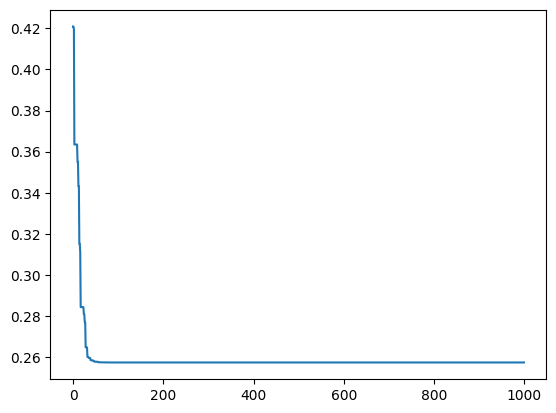

In [6]:
plt.plot(losses)

In [7]:
losses = np.array(losses)
with open("./losses/aco.bin",'wb') as file:
    losses.tofile(file)